In [123]:
# Init
#mystock = 'sgen'
minmax_period = 25

# Load Data and set options
import stockdatalib as sd
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict 
from datetime import datetime
from IPython.core.display import display, HTML
from IPython.display import Javascript
import ipywidgets as widgets
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)
# files: screener_results.csv, constituents_csv.csv
stock_count, stock_fields, sp_df = sd.init_stocks_data('./data/','custom_stocklist.csv')
#sp_df

# Read recommendation file
recomm_df = pd.read_csv("./logs/stock_recommendations_latest.csv")

l1 = recomm_df['Symbol'].to_list()
l2 = recomm_df['Name'].to_list()
l3 = recomm_df['Sector'].to_list()
l = []
for i in range(len(l1)):
    l.append(l1[i]+'-'+l2[i]+' ('+l3[i]+')')
l_all = []
for line, stuck in zip(l, l1):
    l_all.append((line,stuck))
    
w = widgets.Dropdown(
    options=l_all,
    value=l1[0],
    description='Stock:',
)

In [124]:
# Enter stock
global mystock
mystock = recomm_df['Symbol'][0]
def on_change(change):
    global mystock
    if change['type'] == 'change' and change['name'] == 'value':
        mystock = change['new']
        display(Javascript('IPython.notebook.execute_cells([2,3,4,5,6,7,8,9,10,11,12,13])'))

w.observe(on_change)
display(w)

Dropdown(description='Stock:', options=(('AAL-American Airlines Group (Industrials)', 'AAL'), ('ADM-Archer-Dan…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [143]:
# Get stock data and Set range
price_df = sd.GetStockDataFrame(mystock)
price_df = sd.DatesRange(price_df, '2017-08-01') # limit the data since a specific past date or a range

In [144]:
# Print range table
rc = ''
rec_columns=['Symbol','Name','Sector','Recommendation','Close','BuyAt','SellAt']
record = defaultdict(list) 
recomm_list = []

s = mystock
sd.set_stock(s)
stock_info = sd.get_stock_info(s)

if not price_df.empty:
    rc, price_df2, low_df, hi_df, action_df = sd.GetBuySellEnvelope(s,price_df, minmax_period)
    if not rc:
        print("Function Failed")
    else:
        rec = action_df['Recommendation'][0]
        #if(action_df['Recommendation'][0] == 'buy'):
        record = {'Symbol':s.upper(),'Name': stock_info['name'][0], 'Sector':stock_info['sector'][0],
                'Recommendation':rec.upper(),'Close':sd.quote(s).close[0],'BuyAt':action_df['BuyAt'][0],
                'SellAt':action_df['SellAt'][0],'Upside $': round( action_df['SellAt'][0] - sd.quote(s).close[0],2),
                'Upside %': str( round( 100 * ((action_df['SellAt'][0] - sd.quote(s).close[0] )/sd.quote(s).close[0] )  ,2) )+'%',
                'Ave. Hold (days)': 0}

        recomm_list.append(record)
        recomm_df = pd.DataFrame(recomm_list)

link = "<a target='_blank' href='https://snapshot.fidelity.com/fidresearch/snapshot/landing.jhtml#/research?symbol="+s.upper()+"&appCode='>"+s.upper()+"</a>"
recomm_df['Symbol'] = link
HTML(recomm_df.to_html(escape=False))

,Symbol,Name,Sector,Recommendation,Close,BuyAt,SellAt,Upside $,Upside %,Ave. Hold (days)
0,MU,Micron Technology,Information Technology,NO,44.41,34.69,43.77,-0.64,-1.44%,0


MU Buy Sell Env. Chart


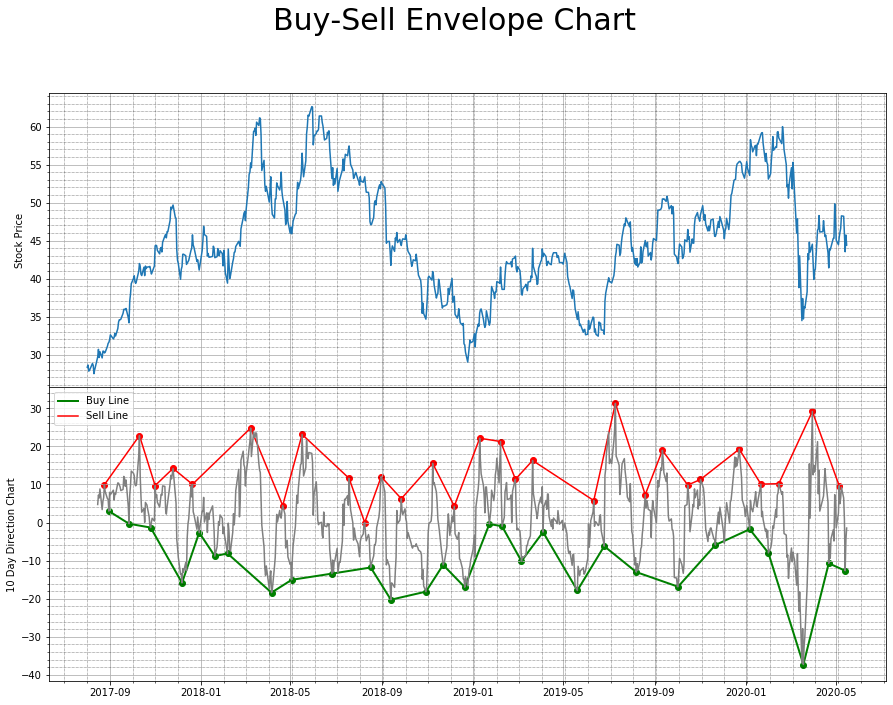

Closed $44.41 on 2020-05-15 13:30:00
Price change range is from  -10.46% to 13.88%
Buy range from  43.53 to 49.57
Last Buy signal on  2020-05-13 13:30:00 Close price was $ 43.53
Last Sell signal on  2020-05-05 13:30:00 Close price was $ 45.41


In [145]:
# Sell-Buy Range
if(not price_df.empty):
    print(mystock.upper()+' Buy Sell Env. Chart')
    price_df3, low_df, hi_df = sd.PlotBuySellEnvelope(price_df, 10)
    
    squote = sd.quote(mystock)
    print('Closed $'+str(squote.close[0]),'on',squote.date[0])
    low_df.dropna(inplace=True)
    hi_df.dropna(inplace=True)

    date_last_buy = low_df.index[-1]
    date_last_sell = hi_df.index[-1]

    price_last_buy = price_df3[price_df3.index == low_df.index[-1]][0]
    price_last_sell = price_df3[price_df3.index == hi_df.index[-1]][0]
 
    ave_min_delta = low_df.mean()
    ave_max_delta = hi_df.mean()
    print("Price change range is from ",str(round(ave_min_delta,2))+"% to", str(round(ave_max_delta,2))+"%")

    if date_last_buy > date_last_sell:
        print("Buy range from ",round( price_last_buy,2), "to", 
              round( price_last_buy + (price_last_buy * ave_max_delta / 100), 2))
    else:
        print("Sell range from ",round( price_last_sell,2), "to", 
              round(price_last_sell + (price_last_sell * ave_min_delta / 100) ,2))

    print("Last Buy signal on ",date_last_buy,"Close price was $",round(price_last_buy,2))
    print("Last Sell signal on ",date_last_sell,"Close price was $",round(price_last_sell,2))

<Figure size 1080x432 with 0 Axes>

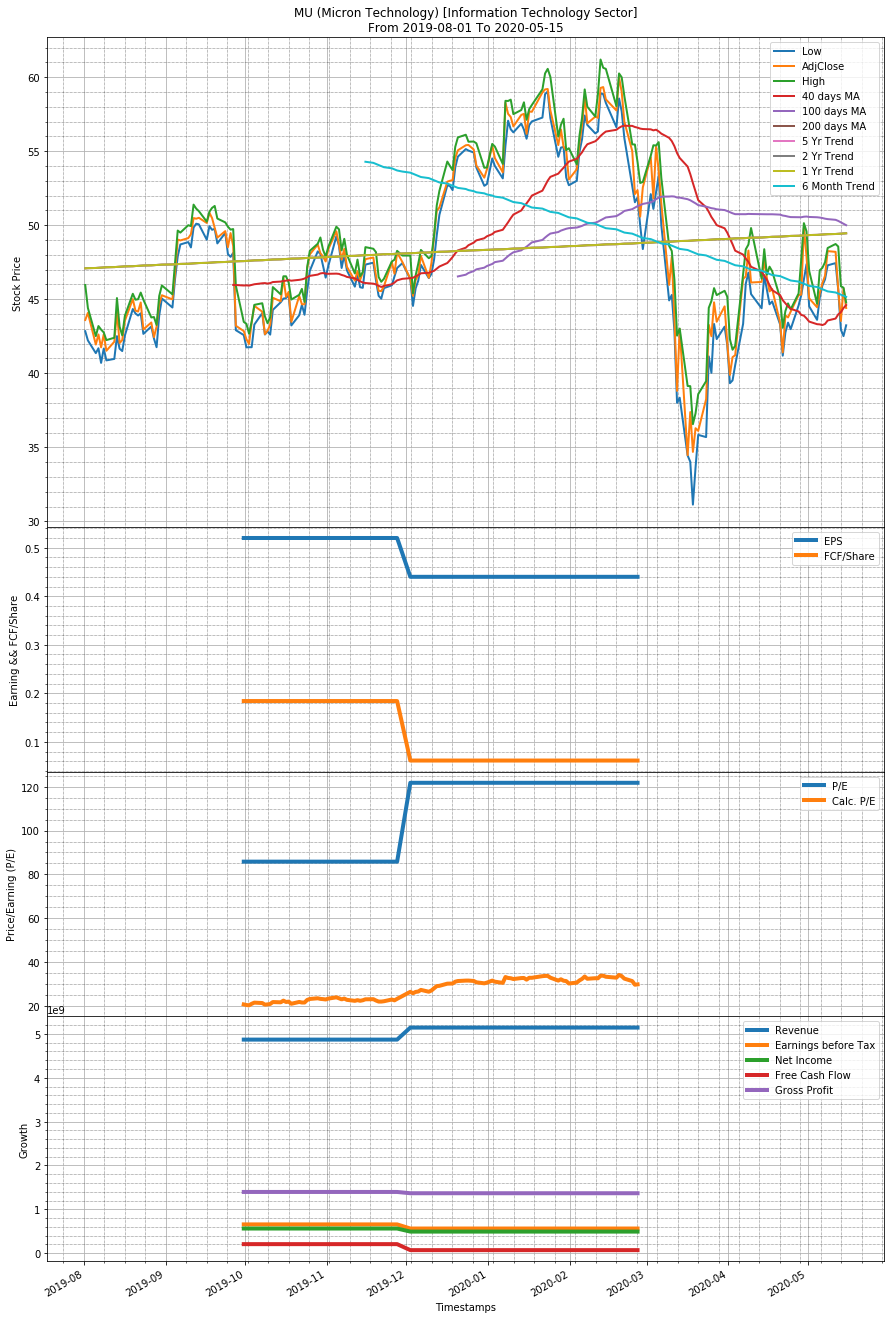

In [146]:
# Plot stock basic charts
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    price_df = sd.DatesRange(price_df, '2019-08-01') # limit the data since a specific past date or a range

    linear_trends = sd.PlotBasicCharts(mystock,price_df)
    plt.show()

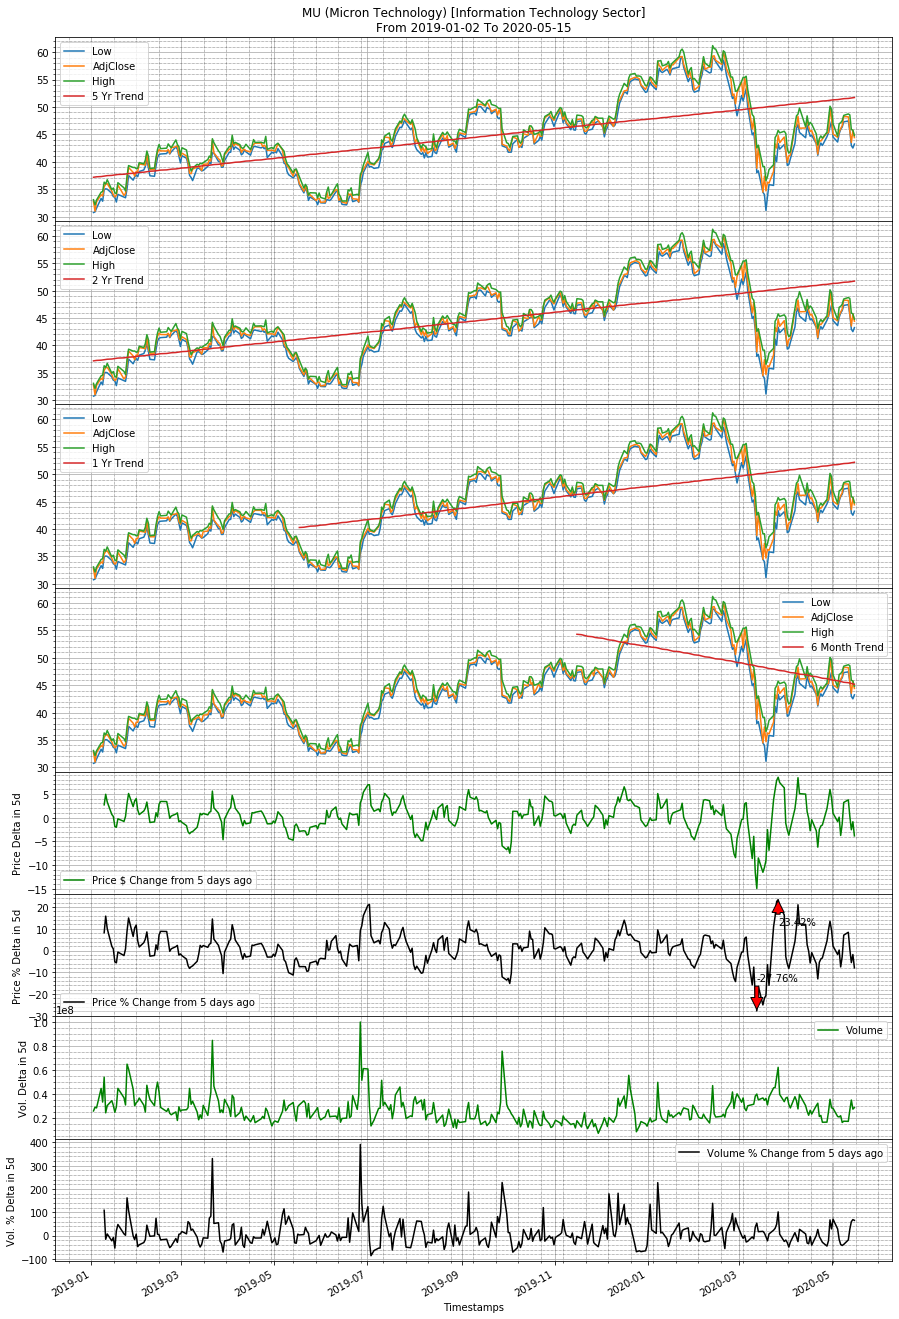

In [147]:
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    price_df = sd.DatesRange(price_df, '2019-01-01')
    price_data_df, maximums_table_df, trends = sd.PlotTrends(mystock,price_df)

In [148]:
if(not price_df.empty):
    for k,v in trends.items():
        print(k,round(v[1],4))

5y Trend 0.0422
2y Trend 0.0422
1y Trend 0.0474
6m Trend -0.0736


In [149]:
if(not price_df.empty):
    maximums_table_df

MU


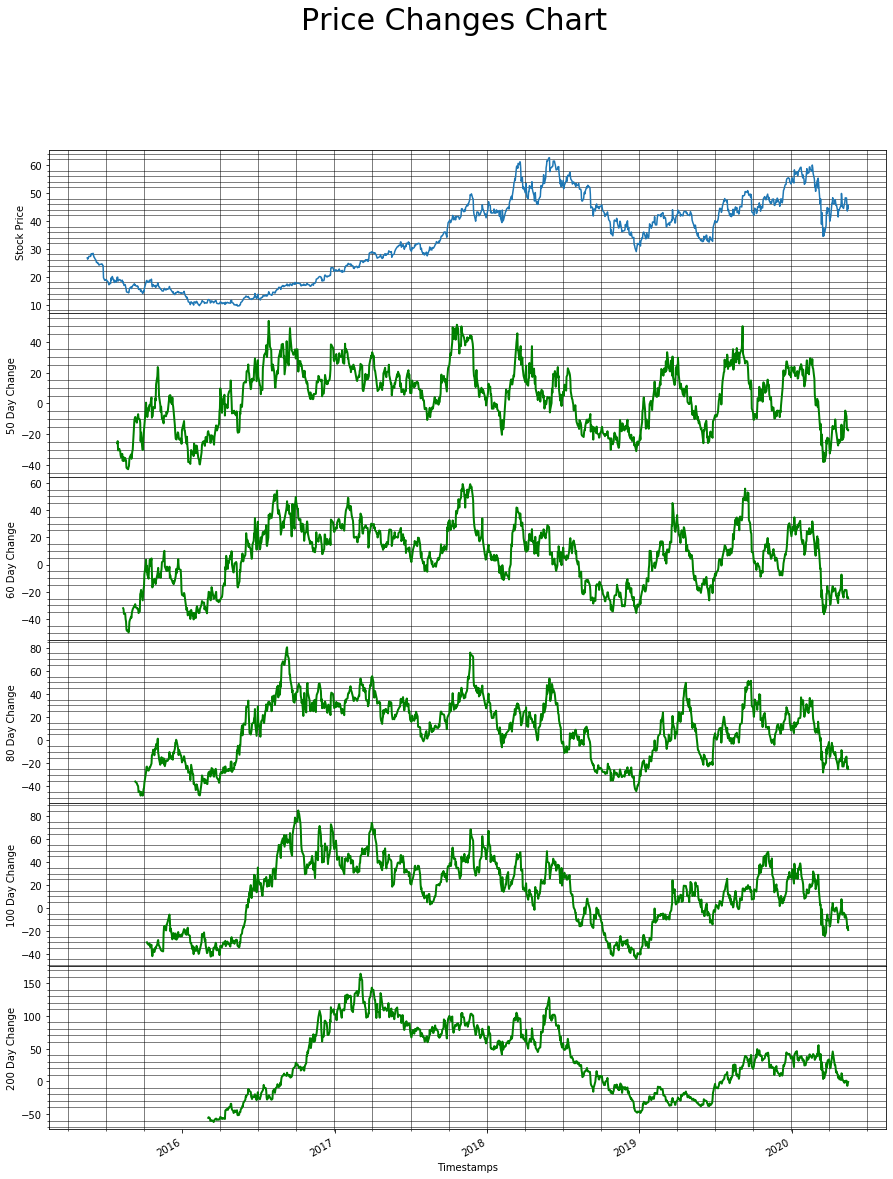

In [150]:
# Set the stock and get the prices dataframe
print(mystock)
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    # You can limit the range if needed
    #price_df = sd.DatesRange(price_df, '2016-02-01')
   
    sd.PlotPriceChangesPercent(price_df,[50,60,80,100,200])

MU


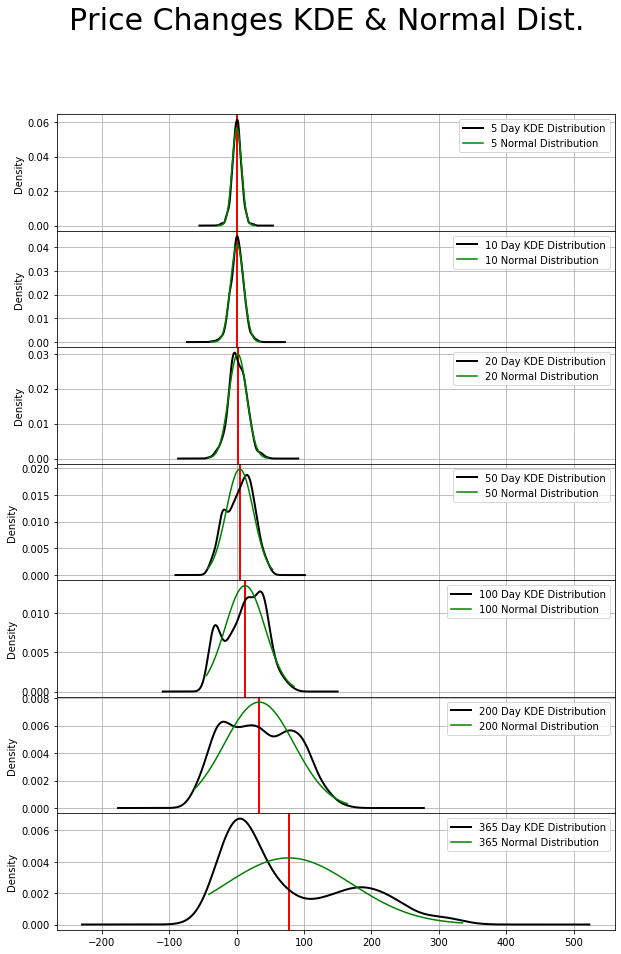

In [151]:
# Set the stock and get the prices dataframe
print(mystock)
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    price_changes, stats = sd.PlotPriceChangesKDE(price_df,[5,10,20,50,100,200,365])
    stats